In [2]:
# load packages
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import torch
from sklearn import preprocessing
from livelossplot import PlotLosses

In [4]:
# Load data
with open('data/msd_full.pickle', 'rb') as fh1:
    msd_data = pickle.load(fh1)

doscaling = 1
if (doscaling == 1):
    xscaler = preprocessing.StandardScaler().fit(msd_data['X_train'])
    #standardize feature values
    X_train = xscaler.transform(msd_data['X_train'])
    X_test = xscaler.transform(msd_data['X_test'])
else:
    X_train = msd_data['X_train']
    X_test = msd_data['X_test']

Y_train = msd_data['Y_train']
Y_test = msd_data['Y_test'].astype('float32')
X_test = X_test.astype('float32')

y_mean = Y_train.mean()
Y_train_keep = Y_train.copy()
Y_test_keep = Y_test.copy()
Y_train = Y_train - y_mean
Y_test = Y_test - y_mean


#validation is the last 10% of training, subtraining is the first 90% of training
nvalid = int(X_train.shape[0] * 0.1)
nsubtrain = X_train.shape[0] - nvalid

X_subtrain = X_train[0:nsubtrain, :].astype('float32')
X_valid = X_train[nsubtrain:, :].astype('float32')
Y_subtrain = Y_train[0:nsubtrain].astype('float32')
Y_valid = Y_train[nsubtrain:].astype('float32')

Y_subtrain_keep = Y_train_keep[0:nsubtrain].astype('float32')
Y_valid_keep = Y_train_keep[nsubtrain:].astype('float32')

print("X_train shape = ", X_train.shape)
print("X_subtrain shape = ", X_subtrain.shape)
print("X_valid shape = ", X_valid.shape)
print("Y_subtrain shape = ", Y_subtrain.shape)
print("Y_valid shape = ", Y_valid.shape)
print("X_test shape = ", X_test.shape)

X_train shape =  (463715, 90)
X_subtrain shape =  (417344, 90)
X_valid shape =  (46371, 90)
Y_subtrain shape =  (417344,)
Y_valid shape =  (46371,)
X_test shape =  (51630, 90)


## Q1. Ordinary Least Square

In [ ]:
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse

In [ ]:
# Train
X_train_withconst = sm.add_constant(X_train)
model = sm.OLS(Y_train,X_train_withconst).fit()

In [ ]:
# coef
print('前五個特徵的參數:', model.params[1:6])

前五個特徵的參數: [ 5.30975265 -2.88088114 -1.53234348  0.05737583 -0.33952889]


In [ ]:
# Predict
X_test_withconst = sm.add_constant(X_test)
ypred = model.predict(X_test_withconst)

# RMSE
print('RMSE:',rmse(Y_test, ypred))

RMSE: 9.510160684544399


## Q2. Multilayer Perceptron

In [5]:
from torch.utils import data

In [6]:
class Dataset(data.Dataset):
    
    def __init__(self, Xnp, Ynp):
        'Initialization, passing Xnp and Ynp'
        self.labels = Ynp
        self.nobs = Xnp.shape[0]        
        self.Xnp = Xnp
        self.Ynp = Ynp
    
    def __len__(self):
        'Denotes the total number of samples'
        return self.nobs
    
    def __getitem__(self, index):
        'Generates one sample of data'        
        X = self.Xnp[index]
        y = self.Ynp[index]
        return X, y

### Create Dataloader

In [7]:
trainset = Dataset(X_train, Y_train)
subtrainset = Dataset(X_subtrain, Y_subtrain)    
validset = Dataset(X_valid, Y_valid)
testset = Dataset(X_test, Y_test)

In [8]:
trainloader = data.DataLoader(trainset, batch_size=1000, shuffle=True, num_workers=0)
subtrainloader = data.DataLoader(subtrainset, batch_size=1000, shuffle=True, num_workers=0)
validloader = data.DataLoader(validset, batch_size=5000, shuffle=True, num_workers=0)
testloader = data.DataLoader(testset, batch_size=10000, shuffle=True, num_workers=0)

### Create MLP

In [9]:
# For validation
def valid(net, loss_fn = torch.nn.MSELoss(reduction='sum')):
    
    loss = 0
    nobs = 0
    rmse = 0
    
    net.eval()
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(validloader):
            inputs, targets = inputs.to(device), targets.to(device)
            targets = targets.reshape((-1, 1))
            outputs = net(inputs)
            sse = sse_fn(outputs, targets)
            loss += sse.item()
            nobs += inputs.shape[0]
        
    rmse = np.sqrt(loss/nobs)
    return rmse

In [10]:
# For test
def test(net, sse_fn = torch.nn.MSELoss(reduction='sum')):
    loss = 0
    nobs = 0
    rmse = 0
    
    net.eval()
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            targets = targets.reshape((-1, 1))
            outputs = net(inputs)
            sse = sse_fn(outputs, targets)
            loss += sse.item()
            nobs += inputs.shape[0]
    
    rmse = np.sqrt(loss/nobs)
    print('Test RMSE =', rmse)

In [11]:
def train(net, optimizer, loss_fn = torch.nn.MSELoss(reduction='sum'), 
          sse_fn = torch.nn.MSELoss(reduction='sum')):
    
    nepoch = 100
    patient = 5000
    plot_interval = 100
    
    # RMSE plot
    liveloss = PlotLosses(step_names = "# of batchs")
    
    best_valid_rmse = float("inf")
    step_count = 0
    train_loss = 0
    train_loss_count = 0
    stop_training = False
    best_step_count = 0
    best_state = dict()
    
    for epoch_id in range(0, nepoch):
        if stop_training:
            break
            
        for batch_idx, (inputs, targets) in enumerate(subtrainloader):
            net.train()
            
            targets = targets.reshape((-1, 1))
            step_count += 1
            
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            
            # calculate training loss
            sse = sse_fn(outputs, targets)
            train_loss += sse.item()
            train_loss_count += inputs.shape[0]
            
            if batch_idx % plot_interval == 0:
                # training RMSE
                logs = {}
                logs['rmse'] = np.sqrt(train_loss / train_loss_count)
                train_loss = 0
                train_loss_count = 0
                
                # do validation
                valid_rmse = valid(net)
                
                logs['val_rmse'] = valid_rmse
                
                # update RMSE plot
                liveloss.update(logs)
                liveloss.send()
                
                if valid_rmse < best_valid_rmse:
                    best_valid_rmse = valid_rmse
                    best_step_count = step_count
                    best_state = {'net': net.state_dict(),
                                  'rmse': valid_rmse,
                                  'step_count': step_count,}
                    
                if step_count > (best_step_count + patient):
                    stop_training = True
                    break
    
    net.load_state_dict(best_state['net'])
    test(net)

In [12]:
D_in = trainset.Xnp.shape[1]
H = 45
D_out = 1

device = "cpu"

net = torch.nn.Sequential(
        torch.nn.Linear(D_in, H),  
        torch.nn.ReLU(), 
        torch.nn.Linear(H, H),
        torch.nn.ReLU(), 
        torch.nn.Linear(H, H),
        torch.nn.ReLU(), 
        torch.nn.Linear(H, H),
        torch.nn.ReLU(), 
        torch.nn.Linear(H, D_out))

net = net.float()
net = net.to(device)

optimizer = torch.optim.SGD(net.parameters(), lr=0.00001, momentum=0, weight_decay = 0)
loss_fn = torch.nn.MSELoss(reduction='sum')

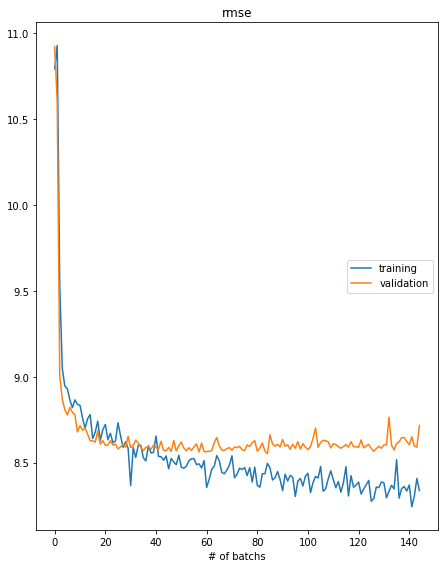

rmse
	training         	 (min:    8.243, max:   10.930, cur:    8.337)
	validation       	 (min:    8.551, max:   10.922, cur:    8.716)
Test RMSE = 9.084758692098365


In [ ]:
train(net, optimizer)

在圖形後段可以看出Training RMSE低於Validation RMSE的狀況，代表模型有出現Overfitting的問題。

## Q.3 討論H = 45, 90, 180的Test RMSE

In [13]:
# train model without plot
def train_no_plot(net, optimizer, loss_fn = torch.nn.MSELoss(reduction='sum'), 
          sse_fn = torch.nn.MSELoss(reduction='sum')):
    
    nepoch = 100
    patient = 5000
    plot_interval = 100
    
    best_valid_rmse = float("inf")
    step_count = 0
    train_loss = 0
    train_loss_count = 0
    stop_training = False
    best_step_count = 0
    best_state = dict()
    
    for epoch_id in range(0, nepoch):
        if stop_training:
            break
            
        for batch_idx, (inputs, targets) in enumerate(subtrainloader):
            net.train()
            
            targets = targets.reshape((-1, 1))
            step_count += 1
            
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            
            # calculate training loss
            sse = sse_fn(outputs, targets)
            train_loss += sse.item()
            train_loss_count += inputs.shape[0]
            
            if batch_idx % plot_interval == 0:
                # training RMSE
                logs = {}
                logs['rmse'] = np.sqrt(train_loss / train_loss_count)
                train_loss = 0
                train_loss_count = 0
                
                # do validation
                valid_rmse = valid(net)
                logs['val_rmse'] = valid_rmse
                
                if valid_rmse < best_valid_rmse:
                    best_valid_rmse = valid_rmse
                    best_step_count = step_count
                    best_state = {'net': net.state_dict(),
                                  'rmse': valid_rmse,
                                  'step_count': step_count,}
                    
                if step_count > (best_step_count + patient):
                    stop_training = True
                    break
    
    net.load_state_dict(best_state['net'])
    test(net)

In [ ]:
Hs = [90, 180]

for H in Hs:
    net = torch.nn.Sequential(
        torch.nn.Linear(D_in, H),  
        torch.nn.ReLU(), 
        torch.nn.Linear(H, H),
        torch.nn.ReLU(), 
        torch.nn.Linear(H, H),
        torch.nn.ReLU(), 
        torch.nn.Linear(H, H),
        torch.nn.ReLU(), 
        torch.nn.Linear(H, D_out))

    net = net.float()
    net = net.to(device)

    optimizer = torch.optim.SGD(net.parameters(), lr=0.00001, momentum=0, weight_decay = 0)
    loss_fn = torch.nn.MSELoss(reduction='sum')

    print('H = ', H)
    train_no_plot(net, optimizer)

H =  90 :
Test RMSE = 8.927460342518902
H =  180 :
Test RMSE = 9.121074894934715


- 表現結果由好到壞依序為：H = 90、H = 45、H = 180
- 以RMSE的數值而言，這三種H的表現並沒有非常顯著的差異
- 推測H的大小對這個數值區間的影響不大
- 也可能是因為模型估計的隨機性而造成這個結果

## Q.4 考慮H = 45, 90, 180與Weight Decay = 0.1, 0.2, 0.4的所有組合

- 模型估計後做表整理Test RMSE，討論H的選擇應為多少較合理?

In [ ]:
weights = [0.1, 0.2, 0.4]
Hs = [45, 90, 180]

for H in Hs:
    for w in weights:
        net = torch.nn.Sequential(
            torch.nn.Linear(D_in, H),  
            torch.nn.ReLU(), 
            torch.nn.Linear(H, H),
            torch.nn.ReLU(), 
            torch.nn.Linear(H, H),
            torch.nn.ReLU(), 
            torch.nn.Linear(H, H),
            torch.nn.ReLU(), 
            torch.nn.Linear(H, D_out))

        net = net.float()
        net = net.to(device)

        optimizer = torch.optim.SGD(net.parameters(), lr=0.00001, momentum=0, weight_decay = w)
        loss_fn = torch.nn.MSELoss(reduction='sum')

        print('H =', H, ',', 'Weight =', w)
        train_no_plot(net, optimizer)

H = 45 , Weight = 0.1
Test RMSE = 8.896010563184845
H = 45 , Weight = 0.2
Test RMSE = 9.003123684523619
H = 45 , Weight = 0.4
Test RMSE = 8.914293133530087
H = 90 , Weight = 0.1
Test RMSE = 9.124534909970023
H = 90 , Weight = 0.2
Test RMSE = 9.019407765026626
H = 90 , Weight = 0.4
Test RMSE = 8.996692694150706
H = 180 , Weight = 0.1
Test RMSE = 9.439185790088992
H = 180 , Weight = 0.2
Test RMSE = 9.128731304592911
H = 180 , Weight = 0.4
Test RMSE = 9.111272803646031


In [ ]:
data={"W = 0.1":[8.89601,9.12453,9.43919], "W = 0.2":[9.00312,9.01941,9.12873], "W = 0.4":[8.91430,8.99669,9.11127]}
df=pd.DataFrame(data,index=["45","90","180"] )
df

,W = 0.1,W = 0.2,W = 0.4
45,8.89601,9.00312,8.91430
90,9.12453,9.01941,8.99669
180,9.43919,9.12873,9.11127


不論weight等於多少，H = 45的表現結果都是最佳的，應該選擇45作為H的數值

## Q.5 MLP with Dropout

In [14]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    device = "cuda"   
else:
    device = "cpu"
print("Running on device: ", device)

Running on device:  cuda


In [ ]:
D_in = trainset.Xnp.shape[1]
H = 90
D_out = 1

net = torch.nn.Sequential(
        torch.nn.Linear(D_in, H),  
        torch.nn.ReLU(),
        torch.nn.Dropout(p = 0.5),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(p = 0.5),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(), 
        torch.nn.Dropout(p = 0.5),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(), 
        torch.nn.Dropout(p = 0.5),
        torch.nn.Linear(H, D_out))

net = net.float()
net = net.to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay = 0)
loss_fn = torch.nn.MSELoss(reduction='sum')

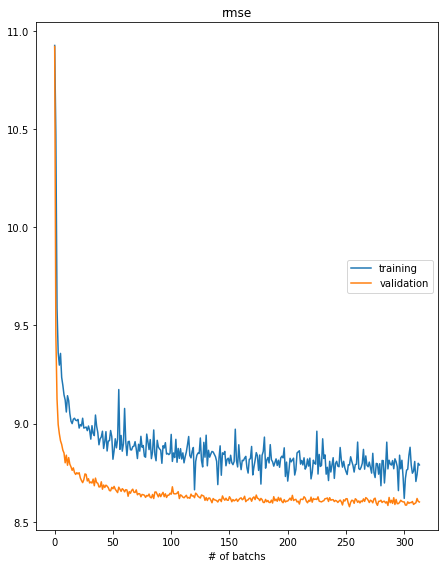

rmse
	training         	 (min:    8.619, max:   10.926, cur:    8.790)
	validation       	 (min:    8.577, max:   10.921, cur:    8.601)
Test RMSE = 8.765866262971732


In [ ]:
train(net, optimizer)

從圖形來看，整個訓練過程中並沒有出現Training RMSE低於Validation RMSE的狀況，可見Dropout可以有效得處理Overfitting的問題

## Q.6 Explore Number of Hidden Units

In [ ]:
Hs = [20, 45, 180, 360]

for H in Hs:
    net = torch.nn.Sequential(
        torch.nn.Linear(D_in, H),  
        torch.nn.ReLU(),
        torch.nn.Dropout(p = 0.5),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(p = 0.5),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(), 
        torch.nn.Dropout(p = 0.5),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(), 
        torch.nn.Dropout(p = 0.5),
        torch.nn.Linear(H, D_out))

    net = net.float()
    net = net.to(device)

    optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay = 0)
    loss_fn = torch.nn.MSELoss(reduction='sum')

    print('H =', H)
    train_no_plot(net, optimizer)

H = 20
Test RMSE = 9.036118464630546
H = 45
Test RMSE = 8.864207165000822
H = 180
Test RMSE = 8.73638674117903
H = 360
Test RMSE = 8.745914177074695


In [ ]:
data={"Test RMSE":[9.03612, 8.86421, 8.76587, 8.73639, 8.74591]}
df=pd.DataFrame(data,index=["20","45","90","180","360"] )
df

,Test RMSE
20,9.03612
45,8.86421
90,8.76587
180,8.73639
360,8.74591


從Test RMSE來看，當hidden layers增加的時候RMSE的表現有越好的趨勢，但到360 layers時RMSE卻回升

## Q.7 L2 + L1 Loss

In [ ]:
def L2L1_loss_fn(outputs, targets, z):
    L2 = z*torch.nn.MSELoss(reduction='sum')(outputs, targets)
    L1 = (1-z)*torch.nn.L1Loss(reduction = 'sum')(outputs, targets)
    return L2+L1

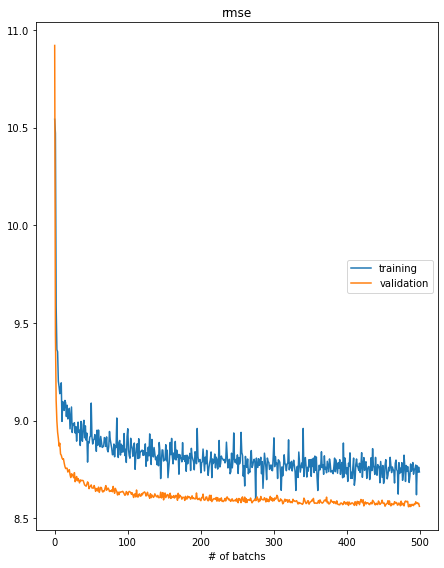

rmse
	training         	 (min:    8.601, max:   10.543, cur:    8.736)
	validation       	 (min:    8.558, max:   10.921, cur:    8.560)
Test RMSE = 8.77282046700769


In [ ]:
D_in = trainset.Xnp.shape[1]
H = 90
Z = 0.5
D_out = 1

net = torch.nn.Sequential(
        torch.nn.Linear(D_in, H),  
        torch.nn.ReLU(),
        torch.nn.Dropout(p = 0.5),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(p = 0.5),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(), 
        torch.nn.Dropout(p = 0.5),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(), 
        torch.nn.Dropout(p = 0.5),
        torch.nn.Linear(H, D_out))

net = net.float()
net = net.to(device)

def L2L1_loss_fn(outputs, targets, z = 0.5):
    L2 = z*torch.nn.MSELoss(reduction='sum')(outputs, targets)
    L1 = (1-z)*torch.nn.L1Loss(reduction = 'sum')(outputs, targets)
    return L2+L1

optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay = 0)
train(net, optimizer, loss_fn = L2L1_loss_fn)

In [ ]:
# 不同的Z值
Zs = [0.0, 0.1, 0.9, 1.0]

D_in = trainset.Xnp.shape[1]
D_out = 1
H = 90

for Z in Zs:
    net = torch.nn.Sequential(
        torch.nn.Linear(D_in, H),  
        torch.nn.ReLU(),
        torch.nn.Dropout(p = 0.5),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(p = 0.5),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(), 
        torch.nn.Dropout(p = 0.5),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(), 
        torch.nn.Dropout(p = 0.5),
        torch.nn.Linear(H, D_out))

    net = net.float()
    net = net.to(device)

    def L2L1_loss_fn(outputs, targets, z = Z):
        L2 = z*torch.nn.MSELoss(reduction='sum')(outputs, targets)
        L1 = (1-z)*torch.nn.L1Loss(reduction = 'sum')(outputs, targets)
        return L2+L1
  
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay = 0)
  
    print('Z =', Z)
    train_no_plot(net, optimizer, loss_fn = L2L1_loss_fn)

Z = 0.0
Test RMSE = 8.986299244352212
Z = 0.1
Test RMSE = 8.771015305849625
Z = 0.9
Test RMSE = 8.774754980195935
Z = 1.0
Test RMSE = 8.766651980268934


In [ ]:
data={"Test RMSE":[8.98630, 8.77102, 8.77282, 8.77475, 8.76665]}
df=pd.DataFrame(data,index=["0.0","0.1","0.5","0.9","1.0"] )
df

,Test RMSE
0.0,8.98630
0.1,8.77102
0.5,8.77282
0.9,8.77475
1.0,8.76665


Z = 0.1時的表現略好一些，Z = 0.5、0.9、1.0時的表現差不多，當Z = 0時的表現最差(可能是因為只有L1 loss)

## Q.8 L2 + Customerized Loss

In [15]:
def qloss(outputs, targets, q = 0.5):
    e = targets - outputs
    loss = torch.max(q*e, (1-q)*(-e))
    return loss.sum()

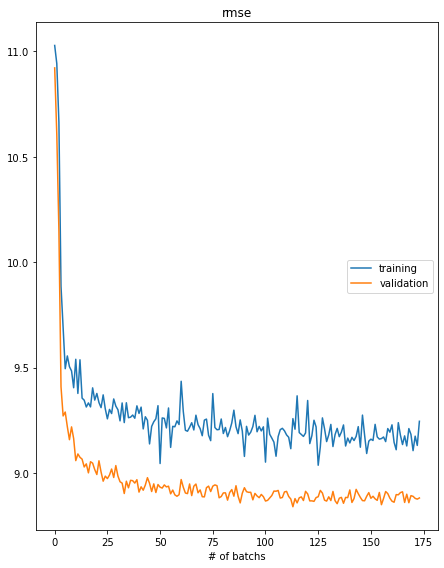

rmse
	training         	 (min:    9.037, max:   11.028, cur:    9.246)
	validation       	 (min:    8.840, max:   10.921, cur:    8.882)
Test RMSE = 8.994210579682655


In [18]:
# Z = 0

H = 90
net = torch.nn.Sequential(
        torch.nn.Linear(D_in, H),  
        torch.nn.ReLU(),
        torch.nn.Dropout(p = 0.5),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(p = 0.5),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(), 
        torch.nn.Dropout(p = 0.5),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(), 
        torch.nn.Dropout(p = 0.5),
        torch.nn.Linear(H, D_out))

net = net.float()
net = net.to(device)

def cust_loss_fn(outputs, targets, z = 0):
    L2 = z*torch.nn.MSELoss(reduction='sum')(outputs, targets)
    return L2+(1-z)*qloss(outputs, targets, q = 0.5)

optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay = 0)
train(net, optimizer, loss_fn = cust_loss_fn)

In [17]:
Zs = [0.1, 0.5, 0.9, 1.0]

for Z in Zs:
    net = torch.nn.Sequential(
        torch.nn.Linear(D_in, H),  
        torch.nn.ReLU(),
        torch.nn.Dropout(p = 0.5),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(),
        torch.nn.Dropout(p = 0.5),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(), 
        torch.nn.Dropout(p = 0.5),
        torch.nn.Linear(H, H),
        torch.nn.ReLU(), 
        torch.nn.Dropout(p = 0.5),
        torch.nn.Linear(H, D_out))

    net = net.float()
    net = net.to(device)
    
    def cust_loss_fn(outputs, targets, z = Z):
        L2 = z*torch.nn.MSELoss(reduction='sum')(outputs, targets)
        return L2+(1-z)*qloss(outputs, targets, q = 0.5)
    
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay = 0)

    print('Z =', Z)
    train_no_plot(net, optimizer, loss_fn = cust_loss_fn)

Z = 0.1
Test RMSE = 8.737367536168202
Z = 0.5
Test RMSE = 8.793561695029062
Z = 0.9
Test RMSE = 8.755101529479667
Z = 1.0
Test RMSE = 8.787332904767949


In [20]:
data={"Test RMSE":[8.99421, 8.73737, 8.79356, 8.75510, 8.78733]}
df=pd.DataFrame(data,index=["0","0.1","0.5","0.9","1.0"] )
df

,Test RMSE
0,8.99421
0.1,8.73737
0.5,8.79356
0.9,8.75510
1.0,8.78733


Z = 0時的表現最差，Z = 0.1, 0.5, 0.9, 1.0的表現差不多，其中以Z = 0.1的表現結果最佳，推測可能是因為兩種loss function相互輔助的關係